Parking Duration: 28.92 minutes, Charge: ₹15.00
Parking Duration: 5.04 minutes, Charge: ₹15.00
Parking Duration: 265.28 minutes, Charge: ₹125.00
Parking Duration: 1.33 minutes, Charge: ₹15.00
Parking Duration: 13.19 minutes, Charge: ₹15.00
Parking Duration: 51.28 minutes, Charge: ₹25.00
Parking Duration: 56.85 minutes, Charge: ₹25.00
Parking Duration: 131.33 minutes, Charge: ₹75.00
Parking Duration: 152.08 minutes, Charge: ₹75.00
Parking Duration: 75.86 minutes, Charge: ₹50.00
Parking Duration: 95.73 minutes, Charge: ₹50.00
Parking Duration: 54.55 minutes, Charge: ₹25.00
Parking Duration: 154.98 minutes, Charge: ₹75.00
Parking Duration: 51.86 minutes, Charge: ₹25.00
Parking Duration: 157.81 minutes, Charge: ₹75.00
Parking Duration: 101.88 minutes, Charge: ₹50.00
Parking Duration: 84.63 minutes, Charge: ₹50.00
Parking Duration: 112.00 minutes, Charge: ₹50.00
Parking Duration: 51.17 minutes, Charge: ₹25.00
Parking Duration: 439.58 minutes, Charge: ₹200.00
Parking Duration: 18.34 minutes,

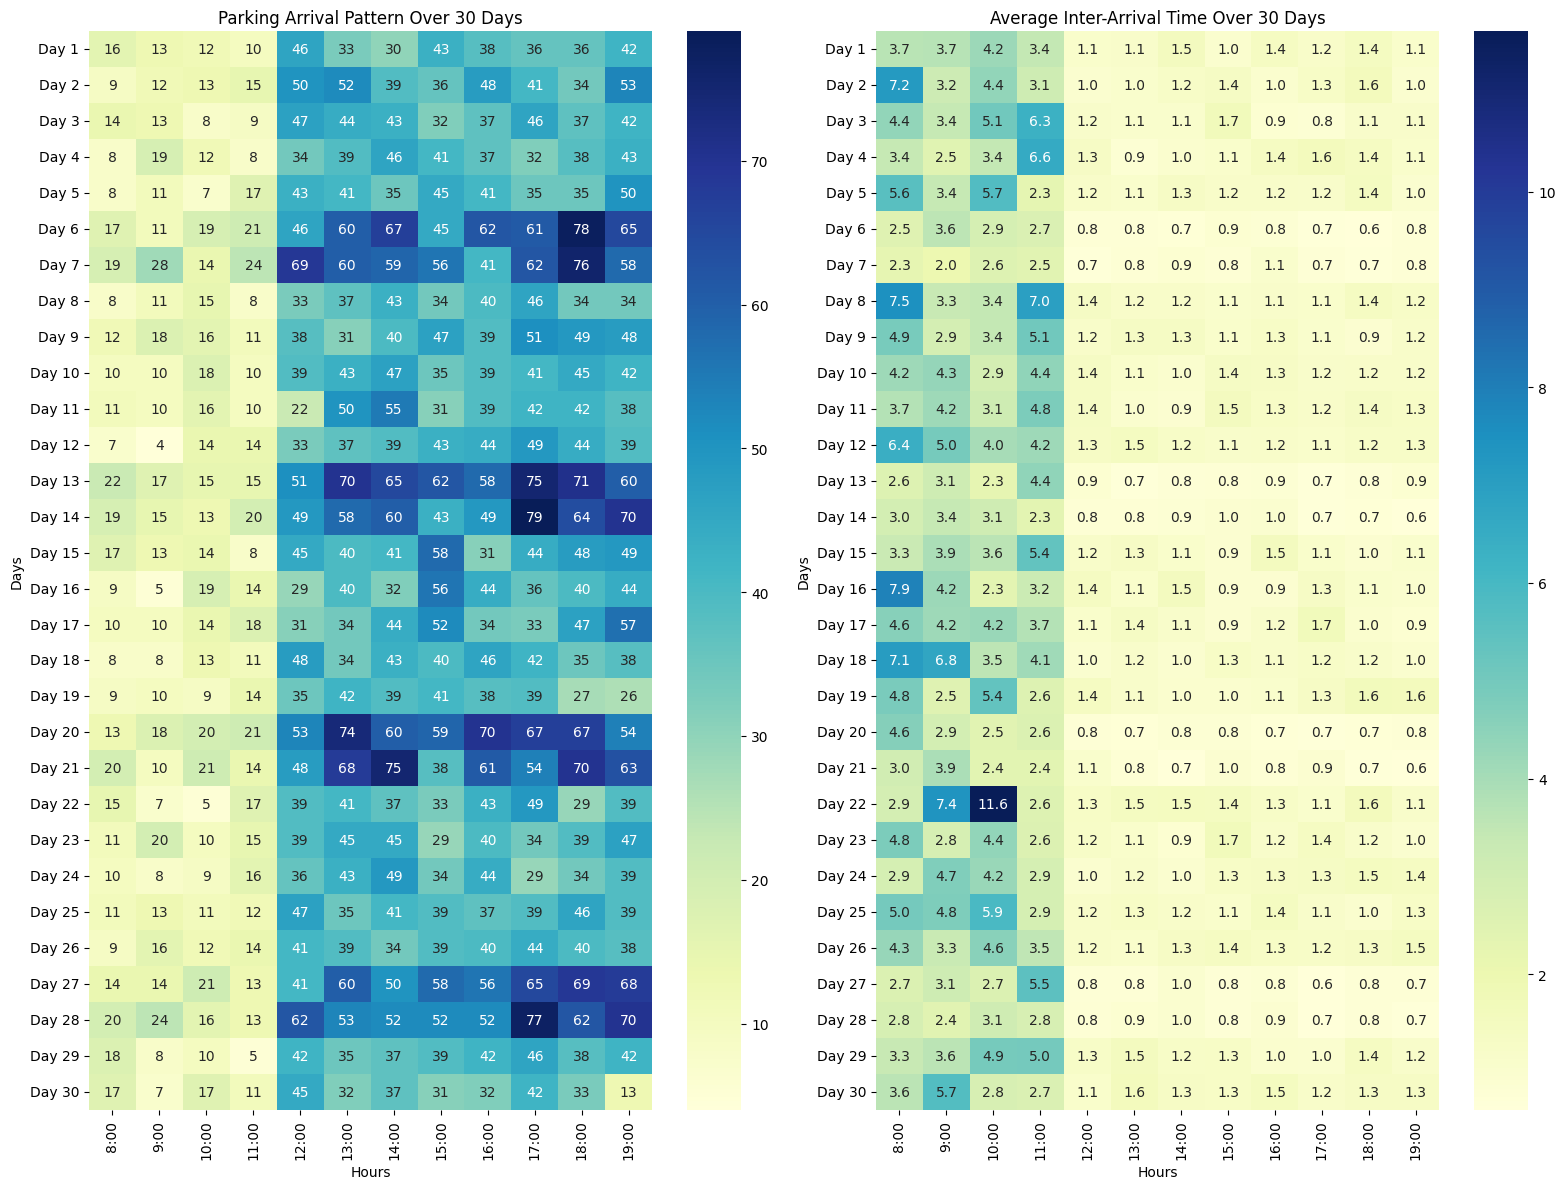

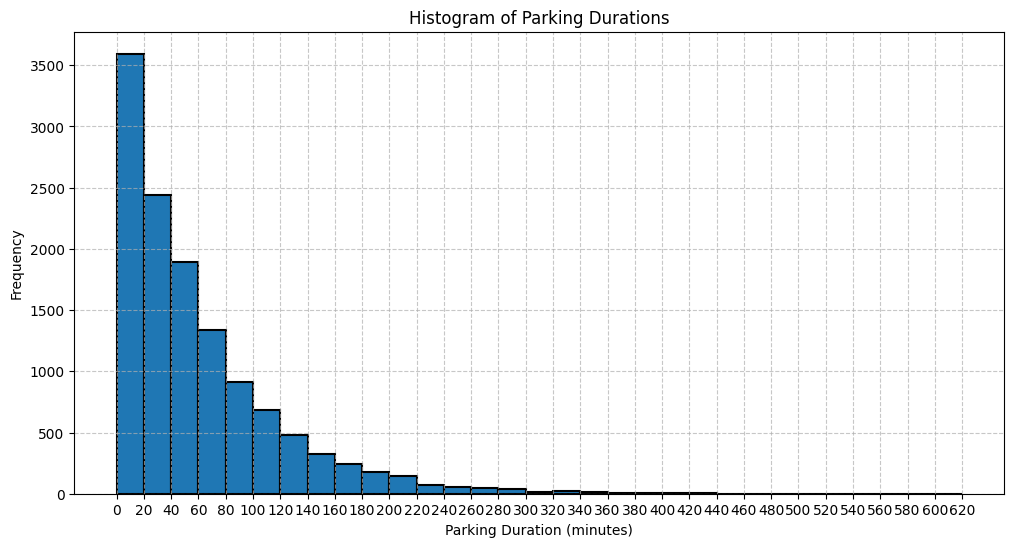


Total Revenue Over 30 Days: ₹443845.00
Total Lost Revenue Due to Lost Customers: ₹45495.00


In [2]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
SIM_DURATION = 30 * 12 * 60  # 30 days, 12 hours per day (8 AM to 8 PM)
CAPACITY = 250
WILLINGNESS_TO_VISIT = 0.80  # 80% willingness to visit

# Arrival rates based on the day of the week and time slots
ARRIVAL_RATES = {
    'Sunday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Monday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Tuesday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Wednesday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Thursday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Friday': [(8, 12, 20), (12, 17, 70), (17, 20, 80)],
    'Saturday': [(8, 12, 20), (12, 17, 70), (17, 20, 80)]
}

# Initialize data for tracking arrivals, inter-arrival times, parking durations, revenue, and parking space utilization
arrival_pattern = np.zeros((30, 12))  # 30 days, 12 hours per day (8 AM to 8 PM)
inter_arrival_times = [[] for _ in range(30 * 12)]  # List of lists for storing inter-arrival times for each time slot
parking_durations = []  # List to store parking durations
total_revenue = 0  # Total revenue accumulator
lost_customers = 0  # Lost customers accumulator
parked_customers = 0  # Parked customers accumulator
utilization_data = []  # List to store occupancy data for utilization calculation

def get_arrival_rate(day, hour):
    """Return the arrival rate based on the day and hour."""
    for start, end, rate in ARRIVAL_RATES[day]:
        if start <= hour < end:
            return rate
    return 0

def calculate_charge(parking_duration):
    """Calculate the charge based on parking duration with ceiling logic."""
    if parking_duration < 30:
        return 15
    else:
        hours = np.ceil(parking_duration / 60)  # Round up to the nearest hour
        return 25 * hours  # Charge ₹25 per hour

def vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time):
    """Simulates vehicle parking behavior, tracks arrivals, inter-arrival times, and calculates revenue."""
    global total_revenue, lost_customers, parked_customers
    
    # Check if the vehicle decides to park based on willingness to visit
    if np.random.random() > WILLINGNESS_TO_VISIT:
        lost_customers += 1
        return  # Vehicle leaves without parking

    # Generate parking duration (in minutes)
    parking_duration = np.random.exponential(60)  # Exponential distribution with mean 60 minutes
    
    # Store parking duration
    parking_durations.append(parking_duration)
    
    # Calculate the charge based on parking duration
    charge = calculate_charge(parking_duration)
    
    # Print the charge for debugging
    print(f"Parking Duration: {parking_duration:.2f} minutes, Charge: ₹{charge:.2f}")
    
    # Update total revenue
    total_revenue += charge
    parked_customers += 1  # Increment parked customers counter
    
    with parking_lot.request() as request:
        yield request
        # Update occupancy data
        current_time = env.now
        num_vehicles = len(parking_lot.users)
        utilization_data.append((current_time, num_vehicles))
        yield env.timeout(parking_duration)
        # Track arrivals for the specific day and hour
        arrival_pattern[day_index, hour_index] += 1  # Use correct indexing for Numpy arrays
        # Store the inter-arrival time
        inter_arrival_times[day_index * 12 + hour_index].append(inter_arrival_time)

def arrival_process(env, parking_lot, day, day_index):
    """Simulates the arrival process based on the day and time."""
    global parked_customers, lost_customers
    while env.now < (day_index + 1) * 12 * 60:  # Simulate only 12 hours per day
        current_hour = (env.now // 60) % 12 + 8  # Convert minutes to simulation hour (8 AM - 8 PM)
        rate = get_arrival_rate(day, current_hour)
        
        # Determine the hour index (0 to 11 for 8 AM to 8 PM)
        hour_index = int(current_hour - 8)  # Adjust index to match 0-11 range
        
        if 0 <= hour_index < 12:  # Ensure hour_index is within valid bounds
            if rate > 0:
                inter_arrival_time = np.random.exponential(60 / rate)  # Convert hourly rate to inter-arrival time
                yield env.timeout(inter_arrival_time)
                env.process(vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time))
            else:
                yield env.timeout(1)  # Wait for 1 minute if no arrival

def run_simulation():
    """Runs the simulation for 30 days."""
    global total_revenue, lost_customers, parked_customers
    env = simpy.Environment()
    parking_lot = simpy.Resource(env, capacity=CAPACITY)

    for day_index in range(30):
        day_name = list(ARRIVAL_RATES.keys())[day_index % 7]  # Cycle through days of the week
        env.process(arrival_process(env, parking_lot, day_name, day_index))

        # Simulate 12 hours of the current day
        env.run(until=(day_index + 1) * 12 * 60)

# Run the simulation
run_simulation()

# Calculate average inter-arrival time for each time slot
average_inter_arrival = np.zeros((30, 12))  # 30 days, 12 hours per day

for i in range(30):
    for j in range(12):
        if inter_arrival_times[i * 12 + j]:  # Check if there are any inter-arrival times recorded
            average_inter_arrival[i, j] = np.mean(inter_arrival_times[i * 12 + j])

# Create DataFrames for the heatmaps
hours = [f"{hour}:00" for hour in range(8, 20)]  # Hour labels from 8 AM to 8 PM
days = [f"Day {i+1}" for i in range(30)]
arrival_df = pd.DataFrame(arrival_pattern, index=days, columns=hours)
average_inter_arrival_df = pd.DataFrame(average_inter_arrival, index=days, columns=hours)

# Print arrival pattern, average inter-arrival time, total revenue, and time slot utilization
print("Parking Arrival Pattern Over 30 Days:")
print(arrival_df)
print("\nAverage Inter-Arrival Time (in minutes) Over 30 Days:")
print(average_inter_arrival_df)

# Calculate parking space utilization for each time slot
time_slot_utilization = {
    '8-11:59': [],
    '12-16:59': [],
    '17-20:00': []
}

# Utility function to get time slot based on the hour
def get_time_slot(hour):
    if 8 <= hour < 12:
        return '8-11:59'
    elif 12 <= hour < 17:
        return '12-16:59'
    elif 17 <= hour < 20:
        return '17-20:00'
    return None

# Compute the total occupied time based on occupancy data and categorize by time slots
previous_time = 0  # Reset previous_time before usage
for current_time, num_vehicles in utilization_data:
    hour = int((current_time // 60) % 12) + 8  # Convert minutes to simulation hour (8 AM - 8 PM)
    time_slot = get_time_slot(hour)
    if time_slot:
        time_spent = current_time - previous_time
        time_slot_utilization[time_slot].append(time_spent * (num_vehicles / CAPACITY))
    previous_time = current_time

# Calculate average utilization for each time slot
total_time_per_slot = {
    '8-11:59': 4 * 60 * 30,  # 4 hours per day, 30 days
    '12-16:59': 5 * 60 * 30,  # 5 hours per day, 30 days
    '17-20:00': 3 * 60 * 30   # 3 hours per day, 30 days
}

average_utilization_by_slot = {
    slot: (np.sum(time_slot_utilization[slot]) / total_time_per_slot[slot]) * 100
    for slot in time_slot_utilization
}

# Print average parking space utilization by time slot
print("\nAverage Parking Space Utilization by Time Slot:")
for slot, utilization in average_utilization_by_slot.items():
    print(f"{slot}: {utilization:.2f}%")

# Calculate percentage of lost customers
total_attempted_arrivals = parked_customers + lost_customers
percentage_lost_customers = (lost_customers / total_attempted_arrivals) * 100 if total_attempted_arrivals > 0 else 0

# Print results
print(f"\nTotal Parked Customers: {parked_customers}")
print(f"Total Lost Customers: {lost_customers}")
print(f"Percentage of Lost Customers: {percentage_lost_customers:.2f}%")

# Plotting the heatmaps
plt.figure(figsize=(16, 12))

# Heatmap for parking arrival pattern
plt.subplot(1, 2, 1)
sns.heatmap(arrival_df, annot=True, cmap="YlGnBu", cbar=True, fmt=".0f")
plt.title("Parking Arrival Pattern Over 30 Days")
plt.xlabel("Hours")
plt.ylabel("Days")

# Heatmap for average inter-arrival time
plt.subplot(1, 2, 2)
sns.heatmap(average_inter_arrival_df, annot=True, cmap="YlGnBu", cbar=True, fmt=".1f")
plt.title("Average Inter-Arrival Time Over 30 Days")
plt.xlabel("Hours")
plt.ylabel("Days")

plt.tight_layout()
plt.show()

# Plot parking duration histogram
plt.figure(figsize=(12, 6))
max_duration = int(max(parking_durations))
bins = range(0, max_duration + 10, 20)  # Create bins with 10-minute intervals
plt.hist(parking_durations, bins=bins, edgecolor='black', linewidth=1.5)  # Increased linewidth

# Customizing x-ticks to show intervals of 10 minutes
plt.xticks(bins)

plt.title("Histogram of Parking Durations")
plt.xlabel("Parking Duration (minutes)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines for better readability

plt.show()

# Calculate lost revenue
lost_revenue = lost_customers * 15  # Assuming average charge for a vehicle is ₹15

print(f"\nTotal Revenue Over 30 Days: ₹{total_revenue:.2f}")
print(f"Total Lost Revenue Due to Lost Customers: ₹{lost_revenue:.2f}")
